In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [92]:
# Load data into a pandas DataFrame
crops = pd.read_csv('Crop_recommendation.csv')

# Extract features containing only the temperature, humidity, ph, month and label columns
features = ['temperature', 'humidity', 'ph', 'month', 'label']

X = crops[features]
y = crops['harvest time']

print(X)

      temperature   humidity        ph      month label
0       20.879744  82.002744  6.502985  September  rice
1       21.770462  80.319644  7.038096  September  rice
2       23.004459  82.320763  7.840207  September  rice
3       26.491096  80.158363  6.980401  September  rice
4       20.130175  81.604873  7.628473  September  rice
...           ...        ...       ...        ...   ...
1295    23.874845  86.792613  6.718725        May  jute
1296    23.928879  88.071123  6.880205        May  jute
1297    24.814412  81.686889  6.861069        May  jute
1298    24.447439  82.286484  6.769346        May  jute
1299    26.574217  73.819949  7.261581        May  jute

[1300 rows x 5 columns]


In [93]:
# Convert categorical features to numerical values and normalize the data
label_encoder = LabelEncoder()
X['month'] = label_encoder.fit_transform(X['month'])
X['label'] = label_encoder.fit_transform(X['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\wan_n\AppData\Local\Temp\ipykernel_15164\2629089431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = label_encoder.fit_transform(X['month'])
C:\Users\wan_n\AppData\Local\Temp\ipykernel_15164\2629089431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'] = label_encoder.fit_transform(X['label'])


In [94]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Create a  KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with KFold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)




Best hyperparameters:  {'max_depth': 7, 'max_features': None, 'n_estimators': 300}
Best cross-validation score:  -50.377604475372564


Test Root Mean Square Error: 6.63


C:\Users\wan_n\AppData\Local\Temp\ipykernel_15164\1489653776.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


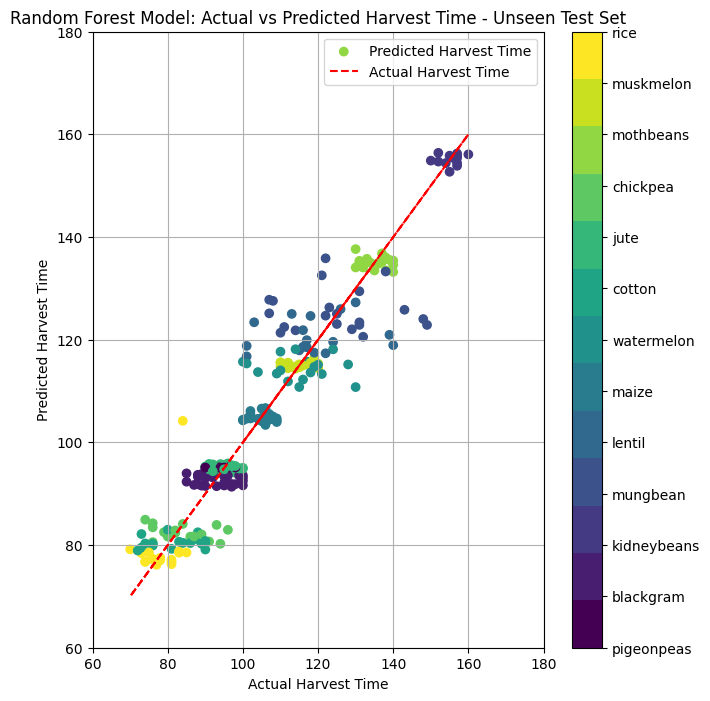

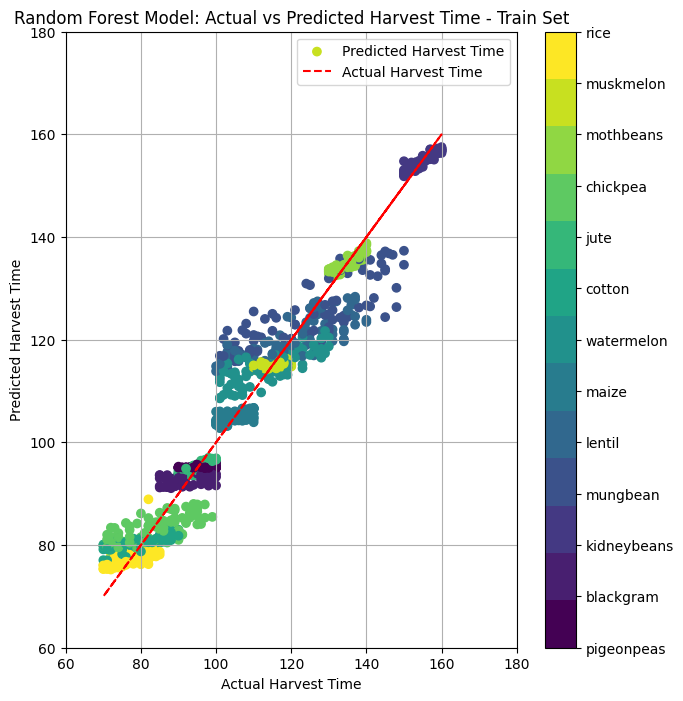

In [95]:
# Make predictions on the test data using the best model
test_pred = grid_search.best_estimator_.predict(X_test)

# Add the predicted harvest time to your test set
X_test['predicted_harvest'] = test_pred

# Convert the numerical labels back to original crop names
X_test['label'] = label_encoder.inverse_transform(X_test['label'])

# Convert 'label' to numeric for plotting
X_test['label_numeric'] = X_test['label'].astype('category').cat.codes

# Get the unique crop types
unique_labels = X_test['label'].unique()

# Create a color map with a different color for each unique crop type
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]
crop_type_colors = dict(zip(unique_labels, colors))

# Create the scatter plot with a colormap for the test set
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_test, test_pred, c=X_test['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Unseen Test Set')
plt.ylim(60, 180)
plt.xlim(60, 180)
plt.legend()
plt.grid(True)

# Create the scatter plot with a colormap for the train set
train_pred = grid_search.best_estimator_.predict(X_train)

X_train['predicted_harvest'] = train_pred

X_train['label'] = label_encoder.inverse_transform(X_train['label'])

# Convert 'label' to numeric for plotting
X_train['label_numeric'] = X_train['label'].astype('category').cat.codes

plt.figure(figsize=(16, 8))
plt.subplot(1,2,2)
scatter = plt.scatter(y_train, train_pred, c=X_train['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_train, y_train, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Train Set')
plt.ylim(60, 180)
plt.xlim(60, 180)
plt.legend()
plt.grid(True)

# Calculate the RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test Root Mean Square Error: {test_rmse:.2f}")

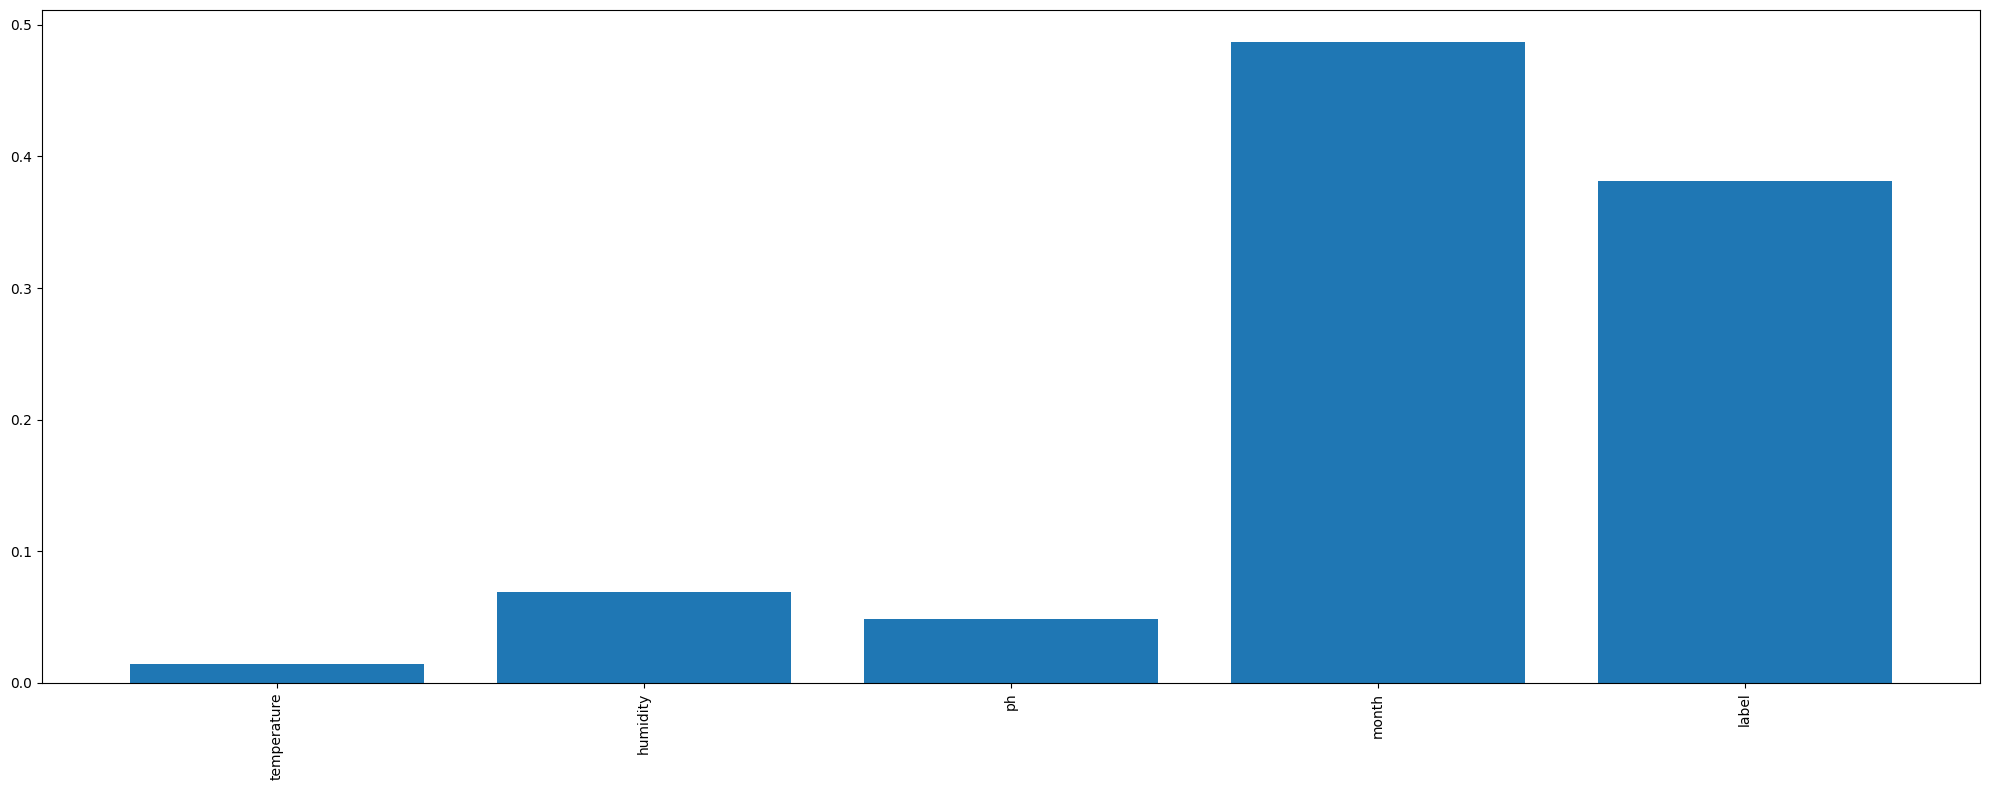

In [96]:
crop_features = crops.drop(['water availability', 'harvest time'], axis=1)
feature_importances = grid_search.best_estimator_.feature_importances_
plt.figure(figsize=(20, 8))
plt.bar(crop_features.columns, feature_importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [ ]:
# # Convert string labels to numerical values (encoding)
# unique_labels = np.unique(y_test)
# label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
# y_test_numeric = np.array([label_mapping[label] for label in y_test])
# y_pred_numeric = np.array([label_mapping[label] for label in y_pred])

# # Create color map with different color for each unique crop type
# cmap = plt.cm.get_cmap('viridis', len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]
# crop_type_colors = dict(zip(unique_labels, colors))

# # Create scatter plot for temperature vs. humidity
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['humidity'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('Humidity')
# ax.set_title('Temperature vs. Humidity (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for humidity vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['humidity'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Humidity')
# ax.set_ylabel('pH')
# ax.set_title('Humidity vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for temperature vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('pH')
# ax.set_title('Temperature vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()